# Préparation des données

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


data_base = pd.read_csv('../vessel-total-clean-final.csv')


# Sélection des 150 premiers bateaux par MMSI
mmsi_list = data_base['mmsi'].dropna().unique()[:150]
data_base_150 = data_base[data_base['mmsi'].isin(mmsi_list)].copy()

# Suppression des lignes incomplètes
data_base_150.dropna(subset=['lat', 'lon', 'sog', 'cog'], inplace=True)

# Agrégation des données de navigation par bateau
traj_features = data_base_150.groupby('mmsi').agg({
    'lat': ['mean', 'std'],
    'lon': ['mean', 'std'],
    'sog': ['mean', 'std'],
    'cog': ['mean', 'std']
}).reset_index()

# Nettoyage des noms de colonnes
traj_features.columns = ['mmsi', 'lat_mean', 'lat_std', 'lon_mean', 'lon_std',
                         'sog_mean', 'sog_std', 'cog_mean', 'cog_std']

# Standardisation des données
scaler = StandardScaler()
X = traj_features.drop(columns='mmsi')
X_scaled = StandardScaler().fit_transform(X)



# Apprentissage non-supervisé

✅ Modèle et scaler sauvegardés avec succès.
k = 2
  Silhouette Score          : 0.2818
  Calinski-Harabasz Score   : 64.96
  Davies-Bouldin Score      : 1.3861
k = 3
  Silhouette Score          : 0.2863
  Calinski-Harabasz Score   : 63.92
  Davies-Bouldin Score      : 1.2612
k = 4
  Silhouette Score          : 0.3255
  Calinski-Harabasz Score   : 63.48
  Davies-Bouldin Score      : 1.1454
k = 5
  Silhouette Score          : 0.3341
  Calinski-Harabasz Score   : 62.97
  Davies-Bouldin Score      : 1.0924
k = 6
  Silhouette Score          : 0.3123
  Calinski-Harabasz Score   : 54.74
  Davies-Bouldin Score      : 1.2481
k = 7
  Silhouette Score          : 0.2697
  Calinski-Harabasz Score   : 54.74
  Davies-Bouldin Score      : 1.2971
k = 8
  Silhouette Score          : 0.2598
  Calinski-Harabasz Score   : 54.44
  Davies-Bouldin Score      : 1.2433
k = 9
  Silhouette Score          : 0.2369
  Calinski-Harabasz Score   : 50.89
  Davies-Bouldin Score      : 1.2307
k = 10
  Silhouette Score   

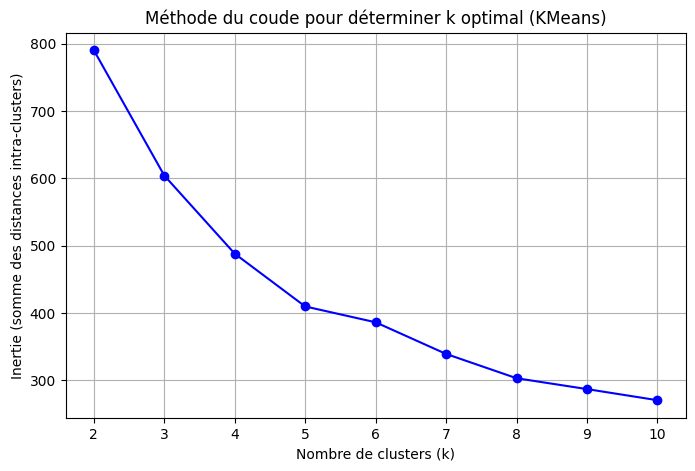

In [ ]:
from sklearn.cluster import KMeans,MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import joblib


# Apprentisage avec KMEANS
kmeans = KMeans(n_clusters=5, random_state=42)
traj_features['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# Sauvegarde du modèle
joblib.dump(kmeans, "model_kmeans_trajectoires.pkl")
joblib.dump(scaler, "scaler_kmeans_trajectoires.pkl") 

print("✅ Modèle et scaler sauvegardés avec succès.")

# Rattacher les clusters aux trajectoires
df_kmeans = data_base_150.merge(traj_features[['mmsi', 'cluster_kmeans']], on='mmsi')

mbk = MiniBatchKMeans(n_clusters=3, batch_size=1000, random_state=42)
traj_features['cluster_mini'] = mbk.fit_predict(X_scaled)
df_mbk = data_base_150.merge(traj_features[['mmsi', 'cluster_mini']], on='mmsi')

# Liste pour stocker les inerties
inertias = []

# Tester k de 1 à 10 
k_range = range(2, 11)


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)

    print(f"k = {k}")
    print("  Silhouette Score          :", round(silhouette_score(X_scaled, labels), 4))
    print("  Calinski-Harabasz Score   :", round(calinski_harabasz_score(X_scaled, labels), 2))
    print("  Davies-Bouldin Score      :", round(davies_bouldin_score(X_scaled, labels), 4))

# Affichage du graphique du coude
plt.figure(figsize=(8, 5))
plt.plot(list(k_range), inertias, marker='o', linestyle='-', color='blue')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (somme des distances intra-clusters)")
plt.title("Méthode du coude pour déterminer k optimal (KMeans)")
plt.grid(True)
plt.xticks(k_range)
plt.show()


# Métriques pour l'apprentissage non-supervisé

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("Silhouette Score :", silhouette_score(X_scaled, traj_features['cluster_kmeans']))
print("Calinski-Harabasz Score :", calinski_harabasz_score(X_scaled, traj_features['cluster_kmeans']))
print("Davies-Bouldin Score :", davies_bouldin_score(X_scaled, traj_features['cluster_kmeans']))

Silhouette Score : 0.3341320092458228
Calinski-Harabasz Score : 62.968222169872476
Davies-Bouldin Score : 1.0924260456663868


# Visualisation sur une carte

In [7]:
import plotly.express as px

# Visualisation sur carte
fig_kmeans = px.scatter_mapbox(df_kmeans, lat="lat", lon="lon", color="cluster_kmeans",mapbox_style="open-street-map", zoom=5,title="Clustering des trajectoires - KMeans")
fig_kmeans.show(renderer="browser")


#fig_mini = px.scatter_mapbox(
    #df_mbk,
    #lat="lat",
    #lon="lon",
    #color="cluster_mini",  
    #zoom=5,
    #mapbox_style="open-street-map",
    #title="Clustering des trajectoires - MiniBatchKMeans",
#)

#fig_mini.show(renderer = "browser")

C:\Users\alban\AppData\Local\Temp\ipykernel_35308\2055389645.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

